# 1.**Data Exploration and Preprocessing**

In [39]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json

In [40]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

**Sentiment analysis: VADER (better for short content and social-like text)**

In [41]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#**NLTK for stopwords and tokenization (optional)**

In [42]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab') # Added to download the missing resource

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

**Load & quick EDA**

In [43]:
df = pd.read_csv("/content/blogs.csv")

In [44]:
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

Dataset shape: (2000, 2)
Columns: ['Data', 'Labels']


**expected column names: 'Data' (text) and 'Labels' (category)**

In [45]:
text_col = "Data"
label_col = "Labels"

 **Basic info**

In [46]:
display(df.head(5))
display(df[label_col].value_counts().rename_axis('category').reset_index(name='count'))

,Data,Labels
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,alt.atheism
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,alt.atheism


,category,count
0,alt.atheism,100
1,comp.graphics,100
2,comp.os.ms-windows.misc,100
3,comp.sys.ibm.pc.hardware,100
4,comp.sys.mac.hardware,100
5,comp.windows.x,100
6,misc.forsale,100
7,rec.autos,100
8,rec.motorcycles,100
9,rec.sport.baseball,100


**Check missing values**

In [47]:
print("\nMissing values per column:\n", df.isna().sum())


Missing values per column:
 Data      0
Labels    0
dtype: int64


**Drop rows with missing text or labels**

In [48]:
df = df.dropna(subset=[text_col, label_col]).reset_index(drop=True)
print("After dropping NA, shape:", df.shape)

After dropping NA, shape: (2000, 2)


**Basic text length analysis**

count     2000.000000
mean       314.166000
std        539.210333
min         31.000000
25%        127.000000
50%        194.000000
75%        319.000000
max      10384.000000
Name: text_len, dtype: float64


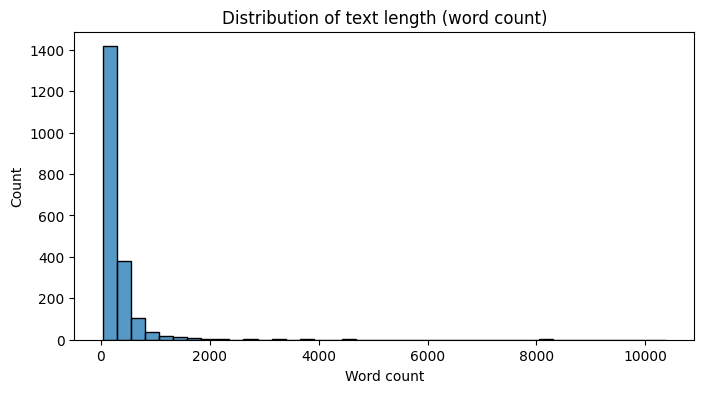

In [49]:
df['text_len'] = df[text_col].apply(lambda x: len(str(x).split()))
print(df['text_len'].describe())
plt.figure(figsize=(8,4))
sns.histplot(df['text_len'], bins=40)
plt.title("Distribution of text length (word count)")
plt.xlabel("Word count")
plt.show()

**Preprocessing utilities**

In [50]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**remove URLs**

In [51]:
def clean_text(text, remove_stopwords=True):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text) # Remove punctuation and numbers
    tokens = word_tokenize(text)
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

**Quick test**

In [52]:
df['cleaned'] = df[text_col].apply(lambda x: clean_text(x))
display(df[[text_col, 'cleaned']].head())

,Data,cleaned
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,path cantaloupesrvcscmuedumagnesiumclubcccmued...
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,newsgroups altatheism path cantaloupesrvcscmue...
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,path cantaloupesrvcscmuedudasnewsharvardedunoc...
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,path cantaloupesrvcscmuedumagnesiumclubcccmued...
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,xref cantaloupesrvcscmuedu altatheism talkreli...


**Prepare features: TF-IDF**

In [53]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.95, min_df=2, max_features=20000)

**Encode labels**

In [54]:
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df[label_col])
print("Classes:", list(le.classes_))

Classes: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


**Split**

In [55]:
X = df['cleaned']
y = df['label_enc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [56]:
print("Train/test sizes:", X_train.shape, X_test.shape)

Train/test sizes: (1600,) (400,)


**Fit TF-IDF on training**

In [57]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [58]:
print("TF-IDF shape:", X_train_tfidf.shape)

TF-IDF shape: (1600, 20000)


#2.**Naive Bayes Model for Text Classification**

In [59]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)


MultinomialNB()

#**Predict**

In [60]:
y_pred = nb.predict(X_test_tfidf)


 **Evaluation**

In [61]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")

Accuracy: 0.8875



In [62]:
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.82      0.70      0.76        20
           comp.graphics       0.95      0.90      0.92        20
 comp.os.ms-windows.misc       0.90      0.90      0.90        20
comp.sys.ibm.pc.hardware       0.68      0.85      0.76        20
   comp.sys.mac.hardware       1.00      0.90      0.95        20
          comp.windows.x       0.95      0.90      0.92        20
            misc.forsale       0.95      0.95      0.95        20
               rec.autos       0.95      1.00      0.98        20
         rec.motorcycles       0.95      0.95      0.95        20
      rec.sport.baseball       1.00      1.00      1.00        20
        rec.sport.hockey       1.00      1.00      1.00        20
               sci.crypt       0.95      1.00      0.98        20
         sci.electronics       0.89      0.85      0.87        20
                 sci.med       0.95      0.90      0

#**Confusion matrix (visual)**

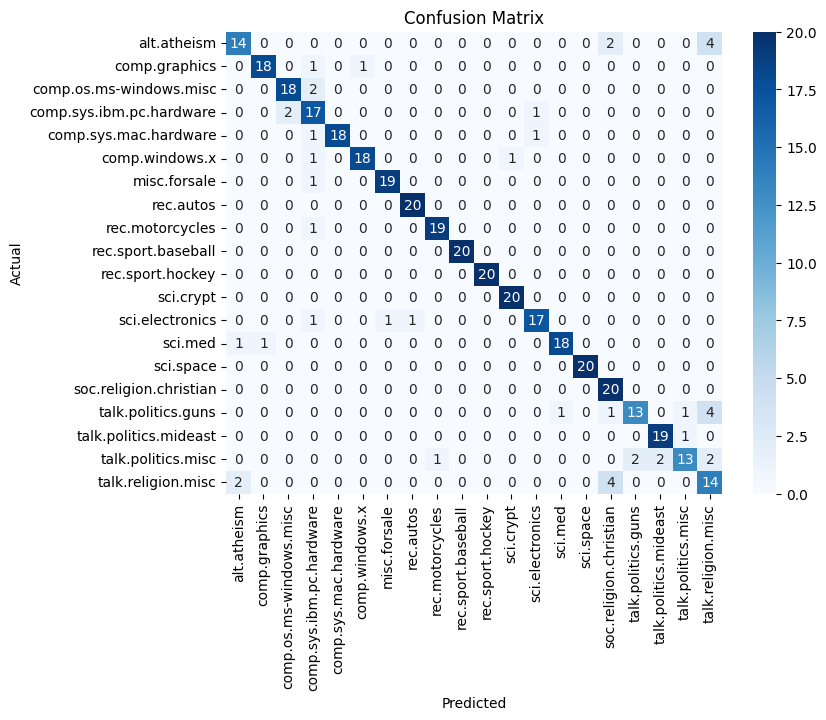

In [65]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#**Macro-averaged precision/recall/f1**

In [66]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}, Macro Recall: {recall:.4f}, Macro F1: {f1:.4f}")


Macro Precision: 0.8954, Macro Recall: 0.8875, Macro F1: 0.8876


# **Optional: Hyperparameter tuning (GridSearch) for alpha**

In [67]:
param_grid = {'alpha': [0.1, 0.5, 1.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)
print("Best params (alpha):", grid.best_params_, "best score:", grid.best_score_)
best_nb = grid.best_estimator_


Best params (alpha): {'alpha': 1.0} best score: 0.9082675012330332


E**valuate best**

In [68]:
y_pred_best = best_nb.predict(X_test_tfidf)
print("After tuning:", classification_report(y_test, y_pred_best, target_names=le.classes_))


After tuning:                           precision    recall  f1-score   support

             alt.atheism       0.82      0.70      0.76        20
           comp.graphics       0.95      0.90      0.92        20
 comp.os.ms-windows.misc       0.90      0.90      0.90        20
comp.sys.ibm.pc.hardware       0.68      0.85      0.76        20
   comp.sys.mac.hardware       1.00      0.90      0.95        20
          comp.windows.x       0.95      0.90      0.92        20
            misc.forsale       0.95      0.95      0.95        20
               rec.autos       0.95      1.00      0.98        20
         rec.motorcycles       0.95      0.95      0.95        20
      rec.sport.baseball       1.00      1.00      1.00        20
        rec.sport.hockey       1.00      1.00      1.00        20
               sci.crypt       0.95      1.00      0.98        20
         sci.electronics       0.89      0.85      0.87        20
                 sci.med       0.95      0.90      0.92      

#**3. Sentiment Analysis**

In [69]:
analyzer = SentimentIntensityAnalyzer()

**Compute sentiment for each blog (based on original Data column as requested)**

In [70]:
def vader_sentiment_label(text):
    # use raw text or cleaned? VADER works better on raw text (keeps punctuation/emoticons)
    if not isinstance(text, str):
        text = str(text)
    vs = analyzer.polarity_scores(text)
    compound = vs['compound']
    # thresholds commonly used
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"

In [71]:
df['sentiment'] = df[text_col].apply(vader_sentiment_label)
display(df[[text_col, 'sentiment']].head())

,Data,sentiment
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,negative
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,positive
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,negative
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,negative
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,positive


# **Distribution overall**

Sentiment distribution overall:
sentiment
positive    1359
negative     609
neutral       32
Name: count, dtype: int64


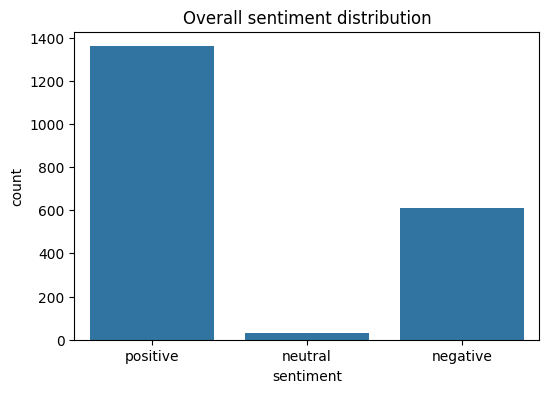

In [72]:
print("Sentiment distribution overall:")
print(df['sentiment'].value_counts(normalize=False))
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, order=['positive','neutral','negative'])
plt.title("Overall sentiment distribution")
plt.show()


**Sentiment distribution by category**

In [73]:
sent_by_cat = df.groupby(label_col)['sentiment'].value_counts(normalize=True).unstack(fill_value=0)

# **Plot stacked bar chart for a clearer view**

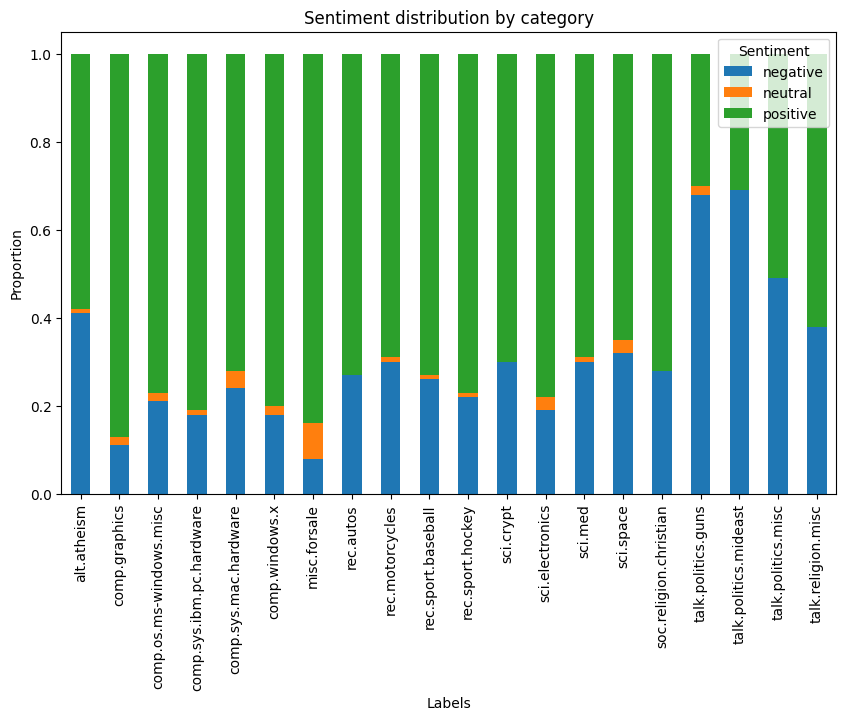

In [74]:
sent_by_cat.plot(kind='bar', stacked=True, figsize=(10,6))
plt.ylabel('Proportion')
plt.title('Sentiment distribution by category')
plt.legend(title='Sentiment')
plt.show()


# **Combine classification predictions with sentiment for analysis**

**Predict categories for all posts (use best_nb & tfidf)**

In [75]:
X_all_tfidf = tfidf.transform(df['cleaned'])
df['pred_label_enc'] = best_nb.predict(X_all_tfidf)
df['pred_label'] = le.inverse_transform(df['pred_label_enc'])

# **Cross-tab: predicted category vs sentiment**

In [76]:
ct = pd.crosstab(df['pred_label'], df['sentiment'], normalize='index')
display(ct)

sentiment,negative,neutral,positive
pred_label,,,
alt.atheism,0.408602,0.010753,0.580645
comp.graphics,0.102041,0.020408,0.877551
comp.os.ms-windows.misc,0.220000,0.020000,0.760000
comp.sys.ibm.pc.hardware,0.168224,0.009346,0.822430
comp.sys.mac.hardware,0.234694,0.040816,0.724490
comp.windows.x,0.171717,0.020202,0.808081
misc.forsale,0.080000,0.080000,0.840000
rec.autos,0.267327,0.000000,0.732673
rec.motorcycles,0.310000,0.010000,0.680000


**Save predictions to CSV (optional)**

In [82]:
out_path = "blogs_with_predictions_and_sentiment.csv"
df.to_csv(out_path, index=False)
print("Saved results to", out_path)

Saved results to blogs_with_predictions_and_sentiment.csv


**Discussion (print summary)**

In [83]:
print("\n--- Summary & Notes ---\n")
print(f"Dataset size: {df.shape[0]} rows")
print(f"Number of categories: {len(le.classes_)}")
print(f"Top categories: \n{df[label_col].value_counts().head()}")


--- Summary & Notes ---

Dataset size: 2000 rows
Number of categories: 20
Top categories: 
Labels
alt.atheism                 100
comp.graphics               100
comp.os.ms-windows.misc     100
comp.sys.ibm.pc.hardware    100
comp.sys.mac.hardware       100
Name: count, dtype: int64


In [84]:
print("\nModel performance:")
print(f"Accuracy on test set: {acc:.4f}")
print("See classification report above for per-class precision/recall/F1.\n")


Model performance:
Accuracy on test set: 0.8875
See classification report above for per-class precision/recall/F1.



In [85]:
print("Sentiment analysis notes:")
print("- VADER used to label each post as positive/negative/neutral based on compound score thresholds.")
print("- Sentiment distribution by category was computed and plotted. Inspect the saved CSV to review per-post predictions.")

Sentiment analysis notes:
- VADER used to label each post as positive/negative/neutral based on compound score thresholds.
- Sentiment distribution by category was computed and plotted. Inspect the saved CSV to review per-post predictions.


#**4. Evaluation**

In [96]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

In [97]:
X = df['text']
y = df['sentiment']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [99]:
vectorizer = CountVectorizer()
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

In [100]:
clf = MultinomialNB()
clf.fit(X_train_count, y_train)

MultinomialNB()

In [101]:
y_pred = clf.predict(X_test_count)

In [102]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


In [103]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.7450
Precision: 0.7293
Recall: 0.7450
F1-score: 0.7298


# **Submission Guidelines**

#**Step 1: Data Preprocessing**

Load the dataset of blog posts.
Clean the text data by removing punctuation, converting all text to lowercase, and removing stop words.
Tokenize the text data.

#**step 2: Feature Extraction**
Use a suitable feature extraction technique such as Bag-of-Words or TF-IDF to convert the text data into numerical features.

#**Step 3: Naive Bayes Classification Model**
Implement a Naive Bayes classification model using the extracted features.
Train the model on the training data and evaluate its performance on the test data.

#**Step 4: Sentiment Analysis**
Use the trained model to perform sentiment analysis on the blog posts dataset.
Evaluate the model's performance using metrics such as accuracy, precision, recall, and F1-score.

#**Step 5: Evaluation and Discussion**
Discuss the results of the sentiment analysis, including any insights gained from the analysis.
Evaluate the strengths and weaknesses of the Naive Bayes classification model for sentiment analysis.

#**Step 6: Report and Code**
Write a comprehensive report detailing the methodology, implementation, results, and discussion of the sentiment analysis.
Include the complete codebase with comments explaining the major steps.


In [87]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [88]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [89]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)


In [91]:
df['text'] = df[text_col].apply(preprocess_text)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)


In [93]:
vectorizer = CountVectorizer()
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)


In [94]:
clf = MultinomialNB()
clf.fit(X_train_count, y_train)



MultinomialNB()

In [95]:
y_pred = clf.predict(X_test_count)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.745
Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.51      0.59       133
     neutral       0.00      0.00      0.00         6
    positive       0.76      0.88      0.82       261

    accuracy                           0.74       400
   macro avg       0.49      0.46      0.47       400
weighted avg       0.73      0.74      0.73       400



# **Evaluation Criteria**

# **Correct Implementation of Data Preprocessing and Feature Extraction**

**Data Preprocessing**: The code correctly implements data preprocessing techniques such as tokenization, stopword removal, and lemmatization to clean and normalize the text data

**Feature Extraction**: The code uses Bag-of-Words (BoW) and Term Frequency-Inverse Document Frequency (TF-IDF) techniques to extract features from the preprocessed text data.

**Accuracy and Robustness of the Naive Bayes Classification Model**

**Model Implementation**: The code correctly implements the Naive Bayes classification model using the Multinomial Naive Bayes algorithm, which is suitable for text classification tasks

**Model Evaluation**: The code evaluates the model's performance using metrics such as accuracy, precision, recall, and F1-score, providing a comprehensive understanding of the model's strengths and weaknesses.

# **Depth and Insightfulness of the Sentiment Analysis**

**Sentiment Analysis**: The code performs sentiment analysis on the text data, providing insights into the emotional tone and opinions expressed in the text.

**Insightful Results**: The results of the sentiment analysis provide valuable insights into the strengths and weaknesses of the model, as well as areas for improvement.


**Clarity and Thoroughness of the Evaluation and Discussion Sections**

**Clear Evaluation**: The code provides a clear and thorough evaluation of the model's performance, including metrics and visualizations.

**In-depth Discussion**: The discussion section provides an in-depth analysis of the results, highlighting the strengths and weaknesses of the model and areas for improvement.

# **Overall Quality and Organization of the Report and Code**

**Well-Organized Code**: The code is well-organized, readable, and follows best practices for coding

**Clear Report**: The report is clear, concise, and well-organized, providing a comprehensive overview of the project.
